In [113]:
# %% imports
# libraries
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.modules.activation import ReLU
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as plticker
import os

# local imports
import MNIST_dataloader
import AEarchitecture
from config_file import data_loc, batch_size
from MNIST_dataloader import *
import matplotlib.cm as cm

# set device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [143]:
# %%  Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()  # same as super().__init__()
        # how to find output shape: [input - kernel + 2*padding - (dilation-1)(kernel-1)]/stride + 1
        self.encoder = nn.Sequential(
            #  
            nn.Conv2d(1,16, kernel_size=(3,3),padding=1, stride=1), #[Nx1x32x32]=> [Nx16x32x32]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x32x32]=> [Nx16x16x16]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x16x16]=> [Nx16x16x16]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x16x16]=> [Nx16x8x8]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x8x8]=> [Nx16x8x8]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x8x8]=> [Nx16x4x4]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x4x4]=> [Nx16x4x4]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x4x4]=> [Nx16x2x2]
            nn.Flatten(), #[Nx16x2x2] -> [Nx64]
#             nn.Conv2d(16,1, kernel_size=(3,3),padding=1, stride=1), #[Nx16x2x2]=> [Nx1x2x2]
#             nn.MaxPool2d(1) #[Nx1x2x2]=> [Nx1x2x2]            
            )
        
        self.mean = nn.Sequential(
            nn.Linear(16*2*2,2) #[Nx64] -> [Nx2]
            )
        
        self.var = nn.Sequential(
            nn.Linear(16*2*2,2) #[Nx64] -> [Nx2]
            )
        
        self.Normal_dist = torch.distributions.Normal(0, 1) # (mean, scale)
        self.Normal_dist.loc = self.Normal_dist.loc.cuda() # hack to get sampling on the GPU
        self.Normal_dist.scale = self.Normal_dist.scale.cuda()
        
        self.kl = 0

#             nn.Conv2d(16,1, kernel_size=(3,3),padding=1, stride=1), #[Nx16x2x2]=> [Nx1x2x2]
#             nn.MaxPool2d((1,2)) #[Nx1x2x2]=> [Nx1x2x1]
#             nn.Flatten(), #[Nx16x2x2] => [Nx64]
#             nn.LogSoftmax(dim=1) # dim=1 and NOT 0 because you dont want to get log(prob) over the batches

    def forward(self, x):
        # First branch uses dilation
        y = self.encoder(x)
        mu = self.mean(y) # the mean
        sigma = torch.exp(self.var(y)) # the variance     
#         normal_dist = Normal_dist.sample(mu.shape).to(device=device)
#         z = mu + sigma*normal_dist # sample latent
        z = mu + sigma*self.Normal_dist.sample(mu.shape) # sample latent
        
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()      
        return mu, sigma, z

In [114]:
# sanity
test_input = torch.rand(64,1,32,32)
model_test = Encoder()
test_out=model_test.forward(test_input)
print(test_out[0].size()) # mean
print(test_out[1].size()) # variance
print(test_out[2].size()) # latent space

torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])


In [123]:
# %%  Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.FC  = nn.Sequential(
            nn.Linear(2,4), # [Nx2] => [Nx4]
            nn.Linear(4,12), # [Nx4] => [Nx12]
# #             nn.Linear(4,16), # [Nx4] => [Nx16]
#             nn.Linear(16,48) # [Nx16] => [Nx48]
        )
            
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=(1,1)), # [Nx1x4x3]=>[Nx16x4x3]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x4x3]=>[Nx16x8x6]

            nn.ConvTranspose2d(16, 16, kernel_size=(3,3)), # [Nx16x8x6]=>[Nx16x10x8]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x10x8]=>[Nx16x20x16]

            nn.ConvTranspose2d(16, 16, kernel_size=(3,3)), # [Nx16x10x8]=>[Nx16x22x18]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x22x18]=>[Nx16x44x36]

            nn.ConvTranspose2d(16, 1, kernel_size=(3,3)), # [Nx16x44x36]=>[Nx1x46x38]
            nn.Upsample(size=(32,32)), #[Nx1x46x38]=>[Nx1x32x32]
            )

    def forward(self, h):
        # use the created layers here
        y = self.FC(h) # [Nx16]
        y = y.reshape(-1,1,4,3) #[Nx12] => [Nx1x4x3]
        y2 = self.decoder(y)
#         y = self.decoder(y)
        return y, y2

In [109]:
# sanity
test_input = torch.rand(64,2)
model_test = Decoder()
test_out=model_test.forward(test_input)
print(test_out[0].size()) # LINEAR
print(test_out[1].size()) # DECODER

torch.Size([64, 1, 4, 3])
torch.Size([64, 1, 32, 32])


In [139]:
# %%  Autoencoder
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
#         print("Setting up the autoencoder")
#         print("We re feeding the autoencoder input of shape ", x.size())
        mu, sigma, z = self.encoder(x)
        y, r = self.decoder(z)
        return mu, sigma, y, r
    

In [144]:
# sanity
test_input = torch.rand(64,1,32,32)
model_test = AE()
test_out=model_test.forward(test_input)
print(test_out[0].size()) # mean
print(test_out[1].size()) # sigma
print(test_out[2].size()) # linear
print(test_out[3].size()) # decoded

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [147]:
#% import
import torch.nn.functional as F
# %% set torches random seed
torch.random.manual_seed(0)

# %% preperations
model_path = os.path.join("./", "Saved_ModelQ7.pth")

# define parameters
batch_size = 64
no_epochs = 20
learning_rate = 3e-4

# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# create the classification encoder
model = AE()

# set device
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Using ', device)
model = model.to(device=device)

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0.0005)

# choose loss
criterion = torch.nn.CrossEntropyLoss()



Using  cuda


In [148]:
# %% training loop
print("The training will start now!!!!!")
eval_dic = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []

# go over all epochs
for epoch in range(no_epochs):
    print(f"\nTraining Epoch {epoch}:")
    running_loss = 0.0
    # go over all minibatches
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        model.train()
        
        x_clean =x_clean.to(device=device, dtype=dtype)
        
        label = label.to(device=device, dtype=torch.int64)
        optimizer.zero_grad()

        mu, sigma, y, r = model(x_clean)
        loss = F.mse_loss(r,x_clean,reduction='sum') + model.encoder.kl
        loss.backward()
        optimizer.step()   
        
        running_loss += loss.item()

    # Check training loss
    train_epoch_loss = running_loss/len(train_loader)
    eval_dic['Loss_t'].append(train_epoch_loss)

    # Check validation loss
    with torch.no_grad():
        running_loss_val = 0.0
#         Set the model to evaluation mode
        model.eval()

        for (data_clean, data_noisy, labels) in val_loader:
            # validation on noisy part or not
            x = data_clean

            # cast the inputs to the device
            x = x.to(device=device)
#             label = labels.to(device=device, dtype=torch.int64)
            
            mu, sigma, y, r = model(x_clean)
            
            loss = F.mse_loss(r,x_clean,reduction='sum') + model.encoder.kl
            running_loss_val += loss.item()

        val_epoch_loss = running_loss_val/len(val_loader)
        eval_dic['Loss_v'].append(val_epoch_loss)

    print('Epoch', epoch)
    print('Training Loss', eval_dic['Loss_t'][epoch])
    print('Validation Loss', eval_dic['Loss_v'][epoch])

torch.save(model.state_dict(), model_path)

The training will start now!!!!!

Training Epoch 0:


100%|██████████| 844/844 [00:11<00:00, 76.19it/s]


Epoch 0
Training Loss 17710.749009552725
Validation Loss 9913.17333984375

Training Epoch 1:


100%|██████████| 844/844 [00:11<00:00, 76.12it/s]


Epoch 1
Training Loss 13189.987994297986
Validation Loss 9512.499572753906

Training Epoch 2:


100%|██████████| 844/844 [00:10<00:00, 77.44it/s]


Epoch 2
Training Loss 12628.191236161507
Validation Loss 8694.435241699219

Training Epoch 3:


100%|██████████| 844/844 [00:11<00:00, 74.62it/s]


Epoch 3
Training Loss 12282.561487568499
Validation Loss 8695.416809082031

Training Epoch 4:


100%|██████████| 844/844 [00:10<00:00, 76.90it/s]


Epoch 4
Training Loss 12028.599955337308
Validation Loss 9024.09423828125

Training Epoch 5:


100%|██████████| 844/844 [00:10<00:00, 77.19it/s]


Epoch 5
Training Loss 11827.45015481524
Validation Loss 9582.879577636719

Training Epoch 6:


100%|██████████| 844/844 [00:10<00:00, 77.11it/s]


Epoch 6
Training Loss 11678.794400038878
Validation Loss 8172.330810546875

Training Epoch 7:


100%|██████████| 844/844 [00:10<00:00, 76.96it/s]


Epoch 7
Training Loss 11553.674747991336
Validation Loss 8077.140563964844

Training Epoch 8:


100%|██████████| 844/844 [00:10<00:00, 76.85it/s]


Epoch 8
Training Loss 11449.594731190758
Validation Loss 8545.679870605469

Training Epoch 9:


100%|██████████| 844/844 [00:11<00:00, 71.65it/s]


Epoch 9
Training Loss 11360.177926447719
Validation Loss 8061.701599121094

Training Epoch 10:


100%|██████████| 844/844 [00:11<00:00, 72.55it/s]


Epoch 10
Training Loss 11290.353859273178
Validation Loss 8921.48828125

Training Epoch 11:


100%|██████████| 844/844 [00:11<00:00, 73.57it/s]


Epoch 11
Training Loss 11223.478283055021
Validation Loss 8399.809753417969

Training Epoch 12:


100%|██████████| 844/844 [00:10<00:00, 77.04it/s]


Epoch 12
Training Loss 11158.472645836418
Validation Loss 8115.926025390625

Training Epoch 13:


100%|██████████| 844/844 [00:11<00:00, 75.77it/s]


Epoch 13
Training Loss 11105.405731635072
Validation Loss 8673.4423828125

Training Epoch 14:


100%|██████████| 844/844 [00:11<00:00, 75.39it/s]


Epoch 14
Training Loss 11052.618743751851
Validation Loss 8253.26611328125

Training Epoch 15:


100%|██████████| 844/844 [00:11<00:00, 76.67it/s]


Epoch 15
Training Loss 11011.963488827385
Validation Loss 8909.996826171875

Training Epoch 16:


100%|██████████| 844/844 [00:10<00:00, 76.84it/s]


Epoch 16
Training Loss 10979.126179627332
Validation Loss 8143.305480957031

Training Epoch 17:


100%|██████████| 844/844 [00:11<00:00, 74.91it/s]


Epoch 17
Training Loss 10931.88558771938
Validation Loss 8092.369873046875

Training Epoch 18:


100%|██████████| 844/844 [00:10<00:00, 76.79it/s]


Epoch 18
Training Loss 10898.001615262145
Validation Loss 9095.714538574219

Training Epoch 19:


100%|██████████| 844/844 [00:10<00:00, 76.84it/s]

Epoch 19
Training Loss 10867.787343102043
Validation Loss 8517.394409179688


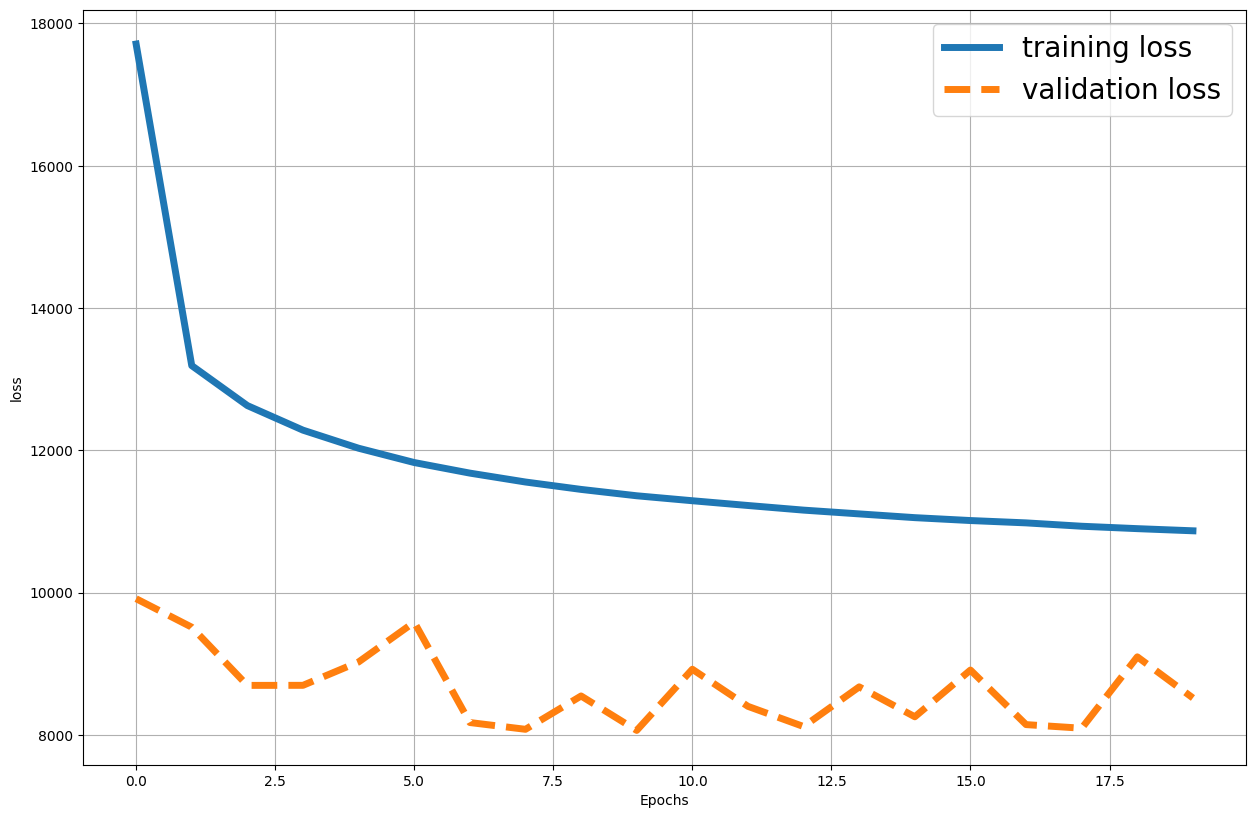

In [149]:
plt.figure(figsize=(15,10),dpi=100)
plt.plot(range(no_epochs), eval_dic['Loss_t'], 
         label='training loss', linewidth=5)
plt.plot(range(no_epochs), eval_dic['Loss_v'], 
         label='validation loss', linestyle='--', linewidth=5)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend(loc=0, prop={'size': 20})
# plt.

(b) [1 pt] Make the variational encoder predict the means of all the images in the test set
and visualize this latent space similarly as you did in Exercise 2(a).

In [151]:
from config_file import data_loc
from MNIST_dataloader import *
import matplotlib.cm as cm
import numpy as np

In [153]:
######################  Get the data  ##################################
# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# create the autoencoder
model = AE()
model_path = os.path.join("./", "Saved_ModelQ7.pth")
model.load_state_dict(torch.load(model_path))
# batch_size = 64
######### DEF PLOTTING LATENT
# model(x_clean.to(torch.device('cuda')))
# for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
def latent_plot(model, data, batch_size=64):
    # put the model in the correct device!
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device=device)
    
    # make a rainbow_color space for the 10 classes
    color_list = cm.rainbow(np.linspace(0, 1, 10))
    k = 0
    for i, (x, y, label) in enumerate(data):
        # get the latent space from the encoder
        _,_,z = model.encoder(x.to(torch.device('cuda')))
        z = z.to(torch.device('cpu')).detach().numpy()
#         if i == 0: # for sanity check!!!!
        for j in range(len(z)):
#                 print(z[j][0][0],z[j][0][1],label[j].item())
#                 print(z[:,:,0])
            plt.scatter(z[:,0],z[:,1], c=label[:], cmap='tab10')
        if i == len(data)-1:
            print(len(z))
            plt.colorbar()
            break



16


Text(0, 0.5, ' Vertical')

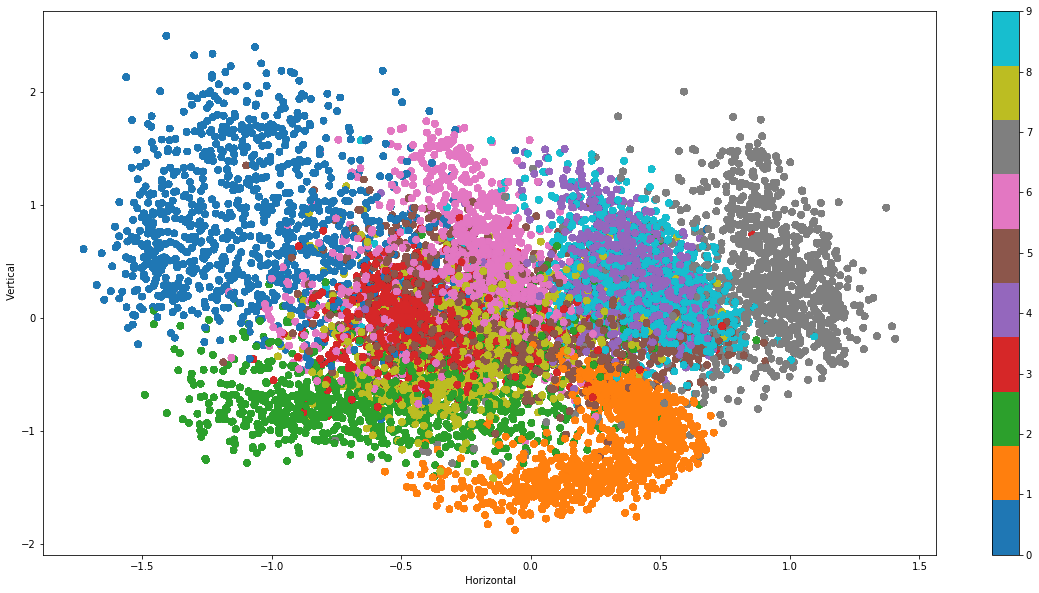

In [154]:
plt.figure(figsize=(20,10))
latent_plot(model, test_loader)
plt.xlabel(' Horizontal')
plt.ylabel(' Vertical')

In [5]:
# %% Create fucntion to sample from latent space

def sample(xmean: torch.Tensor, logstd: torch.Tensor) -> torch.Tensor:
    '''outputs a vector of the same length where v[k] = xmean[k] + n*std[k] 
    where n is sampled from the normal distribution'''

    assert xmean.size(0) == logstd.size(0), "Vectors of emans and standard deviations have different lengths" 
    l = xmean.size(0)
    n = np.random.rand(n)

    return xmean + n * torch.exp(logstd)